I want to develop the linearized 2D wave model described by Kuang (2018).

Assuming that the mean winds are zero, the linearized anelastic equations are given by

\begin{align}
q_t +\bar{q}_z w = Q_2'\\
s_t +\bar{s}_z w = Q_1'\\
w_t  = -\partial x^2 L M B  -d w\\
\end{align}

$L$ and $M$ are operators, $Lf = -\frac{1}{\rho_0(z)}\int_0^z \rho_0 f dz$, and $Mf = + \int_0^z f dz $. The buoyancy $B$ is a function of $\bar{q} +q$ and $\bar{s} + s$. To constrain the constants, Kuang (2018) says that 

>For simplicity, I neglect the virtual effect in the large- scale wave dynamics, which was found to have only a minor contribution, and assume a rigid lid (w =0) at 175 hPa, as a radiating upper boundary condition is not essential for the instabilities that I shall consider.


Kuang, Z. (2018). Linear stability of moist convecting atmospheres Part I: from linear response functions to a simple model and applications to convectively coupled waves. Journal of the Atmospheric Sciences. https://doi.org/10.1175/JAS-D-18-0092.1

## Derivation

\begin{align}
q_t +\bar{q}_z w = Q_2'\\
s_t +\bar{s}_z w = Q_1'\\
u_t + \phi_x =  - d u\\
L \phi = B \\
u_x + H w = 0\\
\end{align}

$Lf = f_z$ and $H w =\frac{1}{\rho_0} (\rho_0 w)_z$.

$H w_t + [-d u - \phi_x]_x = 0$

$H w_t + d H w - \phi_{xx} = 0$

$L H w_t + d L H w -  B_{xx} = 0$

$ LH (\partial_t + d ) W = B_{xx}$


$LH =  \partial_z \frac{1}{\rho_0} \partial_z \rho_0 = A \rho$

This can be discretized. We should have W collocated with S and Q to make the transport equations simpler. Then a suitable discretization of $A$ is given by

$(A)_k v =\partial_z \frac{1}{\rho_0} \frac{v_k-v_{k-1}}{z^k-z^{k-1}}$

$(A)_k v =\partial_z  \frac{v_k-v_{k-1}}{(z^k-z^{k-1})\rho^{k-1/2}}$

$(A)_k v = \frac{1}{z_{k+1/2}-z_{k-1/2}} \left[ \frac{v_{k+1}-v_k}{(z_{k+1}-z_k)\rho^{k+1/2}} - \frac{v_k-v_{k-1}}{(z^k-z^{k-1})\rho^{k-1/2}} \right]$

$(A v)_k = a_k v_{k-1} + b_k v_k + c_k v_{k+1}$

$a_k = \frac{1}{(z_k - z_{k-1})(z_{k+1/2}-z_{k-1/2})\rho_{k-1/2}}$

$b_k =- \frac{1}{(z_{k+1/2}-z_{k-1/2})}\left[  \frac{1}{(z_{k+1} - z_k)\rho_{k+1/2}} + \frac{1}{(z_k - z_{k-1})\rho_{k-1/2}} \right]$

$c_k = \frac{1}{(z_{k+1} - z_k)(z_{k+1/2}-z_{k-1/2})\rho_{k+1/2}}$

then

$(LH w)_k =a_k \rho_{k-1} w_{k-1} + b_k \rho_k w_k + c_k \rho_{k+1} w_{k+1}$

the dirichlet boundary conditions are satisfied by: $w_0 = - w_1 $ and $w_{n+1} = -w_n$. It is not simply $w_0$ because the vertical velocity should be located at the cell center. This shows up as

$(LH w)_1 = - a_1 \rho_{0} w_{1} + b_1 \rho_1 w_1 + c_1 \rho_{2} w_{2} $
and

$(LH w)_n =a_n \rho_{n-1} w_{n-1} + b_n \rho_n w_n - c_n \rho_{n+1} w_{n}.$

In [1]:
from scipy import sparse
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def pad_linear(z):
    return np.r_[2*z[0] - z[1], z, 2*z[-1] - z[-2]]

def centered_to_interface(z):
    z = pad_linear(z)
    return (z[1:] + z[:-1])/2

def get_elliptic_diagonals(rhoi, zi, rho, z):
    rho = pad_linear(rho)
    z = pad_linear(z)
    dz = np.diff(z)
    dzi = np.diff(zi)
    
    a = rho[:-2] / dz[:-1] / dzi / rhoi[:-1]
    b = -rho[1:-1] / dzi  * (1/dz[1:]/rhoi[1:] + 1 / dz[:-1]/rhoi[:-1])
    c = rho[2:] / dz[1:] / dzi / rhoi[1:]
    
    at = a[1:]
    bt = b.copy()
    bt[0] = b[0] - a[0] *  (zi[0] - z[0]) / (z[1]-zi[0])
    bt[-1] = b[-1] - c[-1] * (z[-1] - zi[-1]) / (zi[-1]-z[-2])
    ct = c[:-1]
        
    return at, bt, ct
    
    
def get_elliptic_matrix(*args):
    diags = get_elliptic_diagonals(*args)
    A = np.asarray(sparse.diags(diags, [-1, 0, 1]).todense())
    return A


def get_elliptic_matrix_easy(rho, z):
    """Get elliptic matrix from cell centered rho and z"""
    rho = np.asarray(rho)
    z = np.asarray(z)
    
    rhoi = centered_to_interface(rho)
    zi = centered_to_interface(z)

    return get_elliptic_matrix(rhoi, zi, rho, z)



# I test the elliptic matrix using the method of manufactured solutions:

# test solution
def ans(m, H, c=2, n=32):
    
    # setup grid
    d = H / n
    z = np.arange(n) * d + d/2
    zi = np.arange(n+1) * d
    
    # setup solution
    rho = np.exp(-c * z / H)
    rhoi = np.exp(-c * zi / H)
#     rhoi = centered_to_interface(rho)
    w = np.sin(m*np.pi * z / H)
    
    # setup rhs
    rhs = -c * np.pi * m / H**2 * np.cos(np.pi*m*z/H) - np.pi**2 * m**2/H**2 * np.sin(np.pi * m*z/H)
    
    # get matrix
    A = get_elliptic_matrix(rhoi, zi, rho, z)
    
    return A @ w, rhs

import pytest

def mad(x,y):
    return np.abs(x-y).mean()

def order_of_convergence(n, err):
    return -np.polyfit(np.log(n), np.log(err), 2)[1]

def test_elliptic_order_of_convergence():
    
    err = []
    ns = [5, 10, 40, 100, 1000]
    for n in ns:
        pred, truth = ans(3, 1.0, c=5, n=n)
        err.append(mad(pred, truth))
    assert order_of_convergence(ns, err) == pytest.approx(2.0, rel=.1)


In [2]:
# this test will fail of the order of convergence is less than 2
test_elliptic_order_of_convergence()

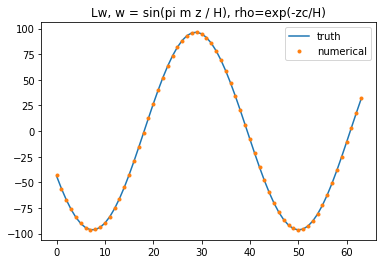

In [3]:
pred, truth = ans(3, 1.0, c=4, n=64)

plt.plot(truth, '-', label='truth')
plt.plot(pred, '.', label='numerical')
plt.legend()
plt.title("Lw, w = sin(pi m z / H), rho=exp(-zc/H)");

# Implementation

Let's use automatic differentiation to do this work, and implement a function using the nonlinear Q1 and Q2.

In [4]:
import torch
from uwnet.utils import centered_difference

In [5]:
def vertically_integrate(f, z_interface):
    dz = z_interface[1:] - z_interface[:-1]
    return torch.cumsum(f*dz, 0)

def deriv(f, z_center):
    return centered_difference(f, 0)/centered_difference(z_center, 0)


class WaveEq:
    def __init__(self, source_fn, base_state, density, interface_heights, center_heights):
        self.base_state = base_state
        self.source_fn = source_fn
        self.density = density
        self.interface_heights = interface_heights
        self.center_heights = center_heights
        
    def buoyancy(self, s, q):
        s0 = self.base_state['SLI']
        return (s-s0)/s0
    
    @property
    def elliptic_operator(self):
        rho = self.density.detach().numpy()
        z = self.center_heights.detach().numpy()
        return get_elliptic_matrix_easy(rho, z)
    
    @property
    def inverse_elliptic_operator(self):
        return torch.tensor(np.linalg.inv(self.elliptic_operator)).float()
    
    def invert_buoyancy(self, s, q):
        b = self.buoyancy(s, q)
        return -torch.matmul(self.inverse_elliptic_operator, b)
    
    @property
    def sz(self):
        return  deriv(self.base_state['SLI'], self.center_heights)
    
    @property
    def qz(self):
        return  deriv(self.base_state['QT'], self.center_heights)
    
    def advection_s(self, w):
        return -self.sz * w
    
    def advection_q(self, w):
        return -self.qz * w
    
    
    def system_matrix(self, k):
        
        s, q = self.base_state['SLI'].detach(), self.base_state['QT'].detach()
        s.requires_grad = True
        q.requires_grad = True
        w = torch.zeros(s.size(0), requires_grad=True)
        
        
        a = wave.invert_buoyancy(s, q)
        adv = wave.advection_s(w)
        
        ins  = {'s': s, 'w': w}
        jac = dict_jacobian({'w': a, 's': adv}, ins)
        
        row1 = torch.cat([jac['s']['s'], jac['s']['w']], dim=-1)
        row2 = torch.cat([k**2 * jac['w']['s'], jac['w']['w']], dim=-1)

        return torch.cat([row1,row2], dim=0).detach().numpy()
    
    def plot_eigs_spectrum(wave):
        k = np.r_[:64] / 160e3
        As = [wave.system_matrix(kk) for kk in k]
        eigs = np.linalg.eigvals(As)/k[:, np.newaxis]

        plt.plot(k, eigs.imag, '.');
        
        
    def get_eigen_pair(self, k):
        return np.linalg.eig(self.system_matrix(k))
        
    def matrices(self):
        k = np.r_[:64] / 160e3
        As = [self.system_matrix(kk) for kk in k]
        return k, As

from src.data import open_data
from uwnet.thermo import interface_heights
from uwnet.jacobian import jacobian, dict_jacobian
import numpy as np

# get base state

def xarray2torch(x):
    return torch.tensor(np.asarray(x), requires_grad=True).float()
ds = open_data('training')
mean = ds.isel(y=32, time=slice(0, 10)).mean(['x', 'time'])


def wave_from_xarray(mean):
    """Wave problem from xarray dataset"""

    base_state = {
        'SLI': xarray2torch(mean.SLI),
        'QT': xarray2torch(mean.QT)
    }

    density = xarray2torch(ds.rho).float()
    zint = torch.tensor(interface_heights(ds.z), requires_grad=True).float()
    zc = xarray2torch(ds.z)

    return WaveEq(None, base_state=base_state, density=density, interface_heights=zint,
                  center_heights=zc)

/Users/noah/anaconda/envs/uwnet/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/Users/noah/anaconda/envs/uwnet/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


/Users/noah/anaconda/envs/uwnet/lib/python3.7/site-packages/ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide


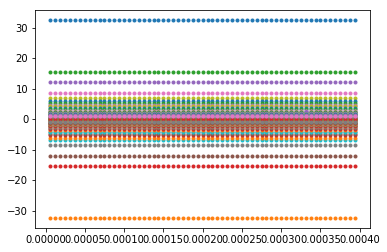

In [6]:
wave = wave_from_xarray(mean)
wave.plot_eigs_spectrum()

In [7]:
def plot_no_scale(x):
    plt.plot(x/np.max(np.abs(x)))

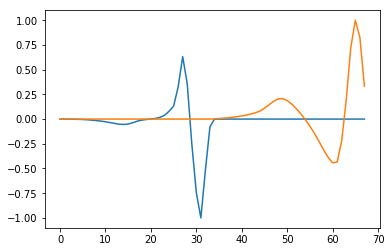

In [8]:
lam, r = wave.get_eigen_pair(1/160e3)
k = 4
plot_no_scale(r[:,k].real)
plot_no_scale(r[:,k].imag)

# Test solution

Let's test the results of this code on a simpler example with constant density, and $s= s_0 + c z$.

$$s_t + c w = 0$$
$$u_t + p_x = 0 $$


$S exp(ikx)_t + c W exp(ikx) $

$U  exp(ikx)_t + ik P =0 $

$ ik U + W_z = 0 $ and $ P_z = s/s_0$

$ -ik W_zzt - k^2 P_z = 0 $ 

$  W_zzt + k^2  s/s0 = 0 $

$ w_{zztt} -  k^2  c /s_0  w = 0$ 

$(\partial z^2 \partial t^2 - k^2 \frac{c}{s_0}) w = 0$

$ w= Z(z) A(t)$

$ Z'' A'' = k^2 \frac{c}{s_0} Z A $

$w = sin(\pi z /H)$

for this mode:

$(-\pi^2 / H^2 \partial_t^2 -  k^2 \frac{c}{s_0}) w = 0$

So that (not sure where the sign error came from)

$(\partial_t^2 +  k^2 \frac{H^2}{\pi^2} \frac{c}{s_0}) w = 0$

this is a wave equaiton with speed $\frac{H}{\pi} \sqrt{\frac{c}{s_0}}$

/Users/noah/anaconda/envs/uwnet/lib/python3.7/site-packages/ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide


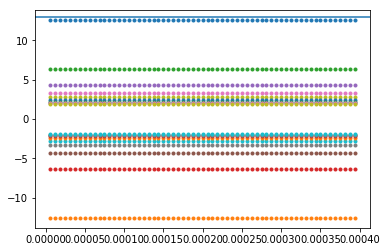

In [9]:
def ones(n):
    return torch.ones(n, requires_grad=True)

def init_test_wave():
    """A test wave problem with s = s0 + cz and rho0 = 1.0"""
    n = 10
    d= 1000
    zc = torch.arange(n).float() * d + d/2
    zint = torch.arange(n+1).float() * d

    c = .005
    s0 = 300
    H = zint[-1]

    density = ones(n)

    base_state = {
        'SLI': zc * c +s0,
        'QT': ones(n)
    }

    speed = H / np.pi * np.sqrt(c/s0)

    return WaveEq(None, base_state=base_state, density=density, interface_heights=zint,
                  center_heights=zc), speed

wave, true_speed = init_test_wave()
wave.plot_eigs_spectrum()

plt.axhline(true_speed)

We can see that the theoretical prediction of the wave speed is very close to the actual maximum wave speed, this could easily be accounted for by redefining s0 to be the midpoint in terms of height.